In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

In [16]:
# make colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap to only use a subset of its range.
    
    Parameters:
    - cmap: The original colormap to truncate.
    - minval: The minimum value of the colormap (between 0 and 1).
    - maxval: The maximum value of the colormap (between 0 and 1).
    - n: The number of points in the new colormap.
    
    Returns:
    - A new colormap that spans the specified range.
    """
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def discrete_colormap(cmap, n_colors):
    """
    Create a discrete colormap with a fixed number of colors.
    
    Parameters:
    - cmap: The original colormap to discretize.
    - n_colors: The number of discrete colors.
    
    Returns:
    - A new colormap with n discrete colors.
    """
    colors = cmap(np.linspace(0, 1, n_colors))
    return LinearSegmentedColormap.from_list(f'discrete_{cmap.name}', colors, N=n_colors)



n_segments = 13
custom_RdBu = truncate_colormap(plt.get_cmap('RdBu_r'), minval=0.1, maxval=0.9)
discrete_RdBu = discrete_colormap(custom_RdBu, n_colors=n_segments)

custom_RdBu_r = truncate_colormap(plt.get_cmap('RdBu'), minval=0.1, maxval=0.9)

custom_BrBG = truncate_colormap(plt.get_cmap('BrBG'), minval=0.1, maxval=0.9)
discrete_BrBG = discrete_colormap(custom_BrBG, n_colors=n_segments)

custom_BrBG_r = truncate_colormap(plt.get_cmap('BrBG_r'), minval=0.1, maxval=0.9)

custom_PuOr_r = truncate_colormap(plt.get_cmap('PuOr_r'), minval=0.15, maxval=0.85)
discrete_PuOr_r = discrete_colormap(custom_PuOr_r, n_colors=n_segments)

custom_PuOr = truncate_colormap(plt.get_cmap('PuOr'), minval=0.15, maxval=0.85)
discrete_PuOr = discrete_colormap(custom_PuOr, n_colors=n_segments)

custom_PiYG = truncate_colormap(plt.get_cmap('PiYG_r'), minval=0.15, maxval=0.85)
discrete_PiYG = discrete_colormap(custom_PiYG, n_colors=n_segments)


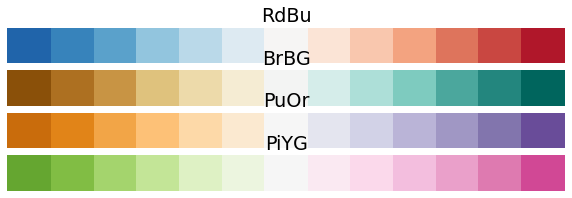

In [17]:
# plot an example of the colormaps
fig, axs = plt.subplots(4,1, figsize=(10, 3))
for ax, cmap, name in zip(axs, [discrete_RdBu, discrete_BrBG, discrete_PuOr, discrete_PiYG], ['RdBu', 'BrBG', 'PuOr', 'PiYG']):
    ax.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto', cmap=cmap)
    ax.set_title(name)
    ax.axis('off')

In [18]:
class GeographicBounds(object):
    def __init__(self, lonMin, lonMax, latMin, latMax):
        self.lonMin = lonMin
        self.lonMax = lonMax
        self.latMin = latMin
        self.latMax = latMax

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
font = {
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

In [21]:
def ttest_with_fdr(months_pert,months_control):
    tstat,pval = stats.ttest_ind(months_pert, months_control,axis=0,equal_var=True)
    #tstat,pval = stats.ttest_rel(months_pert, months_control)

    pvals = np.sort(pval.flatten())
    N = len(pvals)
    i = np.arange(1,N+1)
    a = 0.1
    below = pvals<(a*i/N)
    below_locs = np.where(below)[0]
    if len(below_locs)>0:
        max_below = np.max(below_locs)
        threshold = pvals[max_below]
    else:
        threshold = pvals[0]
    return pval,threshold
    

In [22]:
def load_seasonal_data(experiment,var,months='JFM'):
    if months == 'JFM':
        months_flag = '-JFM'
    else:
        months_flag = ''
    #dat = xr.open_dataarray(f'/glade/campaign/univ/ucla0061/mcb/postprocessed/{experiment}-{var}-quarterly{months_flag}.nc')
    dat = xr.open_dataarray(f'/glade/derecho/scratch/wkrantz/postprocessed/{experiment}-{var}-quarterly{months_flag}.nc')
    return dat

In [26]:
def plot_seasonal_diffs_with_ttest(exp_pert,exp_control,var, vmin, vmax,
                                    standardize=False,lev=False,
                                  domain='gbr',months='JFM',
                                  num_segments = 11):

    
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction','TREFHT':'T 2m'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C','TREFHT':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W/m$^2$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-2}$'}
    
    levdict = {'14':'200 hPa','20':'500 hPa','25':'850 hPa'}
    grey = '#908085'


    
    control = 'derecho-som-control-qdpnoise1_2_control-all'
    perts = ['derecho-som-anom-eez-40DJF-all',
                'derecho-som-anom-eez-20-all',
             'derecho-som-anom-eez-40-all',
             'derecho-som-anom-eez-60-all']

    pertnames = ["40 W m$^{-2}$ DJF", "20 W m$^{-2}$", "40 W m$^{-2}$", "60 W m$^{-2}$"]

    
    pert_datas = [load_seasonal_data(exp_pert,var,months=months) for exp_pert in perts]
    control_data = load_seasonal_data(exp_control,var,months=months)

    cmap = custom_PiYG
    
    if lev:
        pert_datas=[pert_data.isel(lev=lev) for pert_data in pert_datas]
        control_data=control_data.isel(lev=lev)
    
    if var=='PRECT':
        pert_datas = [pert_data*24*24*60*1000 for pert_data in pert_datas]
        control_data = control_data*24*24*60*1000
        cmap = custom_BrBG
        
    if var=='PS':
        pert_datas = [pert_data/100 for pert_data in pert_datas]
        control_data=control_data/100
        cmap = custom_PuOr

    if var=='SF':
        pert_datas = [pert_data * 1e-6 for pert_data in pert_datas]
        control_data = control_data * 1e-6
        cmap = custom_PuOr

    if var=='FLUT':
        cmap = custom_PuOr

    if var=='Z3':
        cmap = custom_PiYG

    if var=='SST':
        cmap = custom_RdBu
    if var=='TREFHT':
        cmap = custom_RdBu
    if var=='TS':
        cmap = custom_RdBu
        

    cmap = discrete_colormap(cmap, n_colors=num_segments)
    
    if months=='DJF':
        season_dict = {'DJF':12,'MAM':3,'JJA':6,'SON':9}
    elif months=='JFM':
        season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}

    fig = plt.figure(figsize=(18, 11.5))
    plt.subplots_adjust(left=0.03, right=0.9, bottom=0.05, top=0.93, wspace=0.05, hspace=0.05)
    proj = ccrs.PlateCarree(180)

    for k, pert_data in enumerate(pert_datas):

        ######### make seasonal differences#############
        seas_avg_diffs = []
        seas_sigmasks = []
        for season in season_dict:
            month = season_dict[season]
            months_pert = pert_data.sel(time=pert_data.time.dt.month==month)
            months_control = control_data.sel(time=control_data.time.dt.month==month)
    
            #tstat,pval = stats.ttest_ind(months_pert, months_control,equal_var=True)
            #p_fdr=p
            pval,p_fdr = ttest_with_fdr(months_pert, months_control)
    
            seas_avg_diff = (months_pert.mean(dim='time') - months_control.mean(dim='time'))
            if standardize:
                seas_avg_diff = seas_avg_diff/months_control.std(dim='time')
    
                
            pval_xr = xr.DataArray(pval, dims=seas_avg_diff.dims, coords=seas_avg_diff.coords)
    
            diff_sigmask = pval_xr.where(pval<=p_fdr)
            # pre-process the data to just zeros and ones
            diff_sigmask = diff_sigmask.fillna(0)
            diff_sigmask = xr.where(diff_sigmask > 0, 1, 0)
            
            seas_avg_diffs.append(seas_avg_diff)
            seas_sigmasks.append(diff_sigmask)
    

        ######### plot ###############

        for i,season in enumerate(season_dict):
            
            ax=plt.subplot(4,4,(4*i)+k+1,projection=proj)

            
            fill = seas_avg_diffs[i].plot(ax=ax,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),add_colorbar=False)
            cs = seas_sigmasks[i].plot.contourf(levels=[0.8,1.0],hatches=['','....'],colors='none',add_colorbar=False,transform=ccrs.PlateCarree())#levels=[0,1],hatches=['xxx',''],alpha=.2)
            ax.set_title('')
            for j, collection in enumerate(cs.collections):
                collection.set_edgecolor('k')
                collection.set_linewidth(0)
                
    
            # fill in the land area with white
            if var == 'SST':
                ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='white', linewidth=0.5))
            ax.coastlines(linewidth=0.5)
            if domain=='global':
                pass
            elif domain == 'mostly_global':
                ax.set_extent((120,-90,-80,70), crs=proj)
            else:
                #bounds = GeographicBounds(120,180,-50,10)
                bounds = GeographicBounds(-100,0,-60,30)
                ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=proj)
    
                
            if k==0:
                ax.set_ylabel(season)

                
            if i==0:
                ax.set_title(pertnames[k])
    
    
            #ax.gridlines(draw_labels=True)
            #plt.colorbar(fill, orientation='horizontal')


    for i, season in enumerate(season_dict):
        fig.text(0.02, 0.85 - i*0.23, season, va='center', ha='right', rotation='vertical', fontsize=16,)
    # ########### add colobar ##############

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    if standardize:
        label_units = "$\sigma$"
    else:
        label_units = labeldict[var]
    
    cbar = fig.colorbar(fill, cax=cbar_ax,label=label_units, extend='both')

    ticks = np.linspace(vmin, vmax, num_segments + 1)
    cbar.set_ticks(ticks)

    # Define the labels for the colorbar
    labels = [f'{tick:.1f}' for tick in ticks]
    cbar.set_ticklabels(labels)


    
    title = '$\Delta$' + namedict[var]
    if standardize:
         title = title + "/$\sigma$" + namedict[var]
        
    if lev:
         title = title + ' ' +levdict[str(lev)]


    # if '40' in exp_pert:
    #     forcing_str = '40 W/m$^2$'
    #     if 'DJF' in exp_pert:
    #         forcing_str = forcing_str + ' DJF'
    # elif '20' in exp_pert:
    #     forcing_str = '20 W/m$^2$'
    # elif '20' in exp_pert:
    #     forcing_str = '20 W/m$^2$'
    # elif '60' in exp_pert:
    #     forcing_str = '60 W/m$^2$'

    # title = title + ' - ' + forcing_str

    # # make super title for the whole plot
    plt.suptitle(title, fontweight='bold')
    
    if standardize:
        std_str = 'std'
    else:
        std_str = ''
    if lev==False:
        lev=''
    saveloc = f'/glade/u/home/wkrantz/new_MCB_teleconnections/figures/supp_figures/seas_diff_{exp_pert}_{exp_control}_{var}_{domain}_{std_str}_{lev}'

    
    plt.savefig(saveloc+'.png',dpi=400,bbox_inches='tight')
    #plt.show()
    
    del pert_datas
    del control_data
    del months_control
    del months_pert

# Standard set of plots

In [27]:
control = 'derecho-som-control-qdpnoise1_2_control-all'
pert = 'derecho-som-anom-eez-40-all'
#pert = 'derecho-som-anom-mp-40DJF-b55'
#pert = 'derecho-som-anom-eez-40DJF-all'`

In [28]:
font = {
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

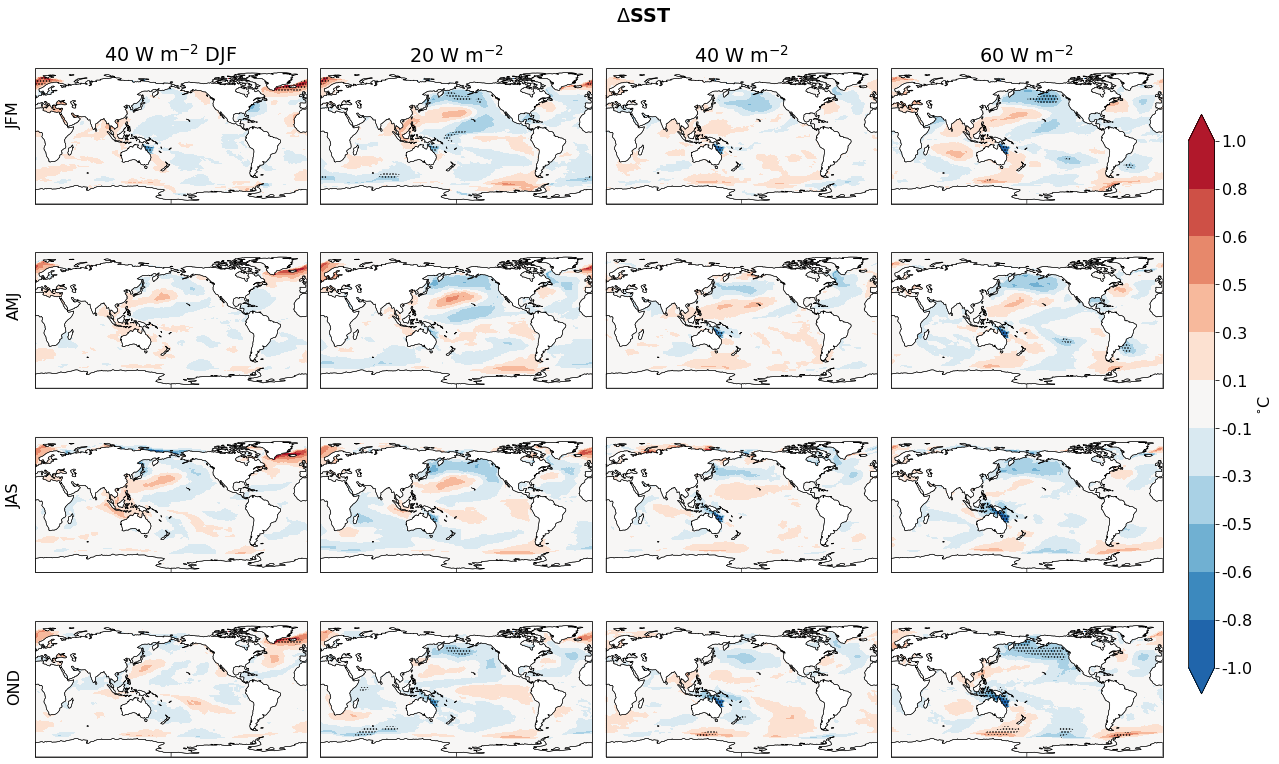

In [29]:
plot_seasonal_diffs_with_ttest(pert,control,'SST', -1, 1, standardize=False, domain = 'global')

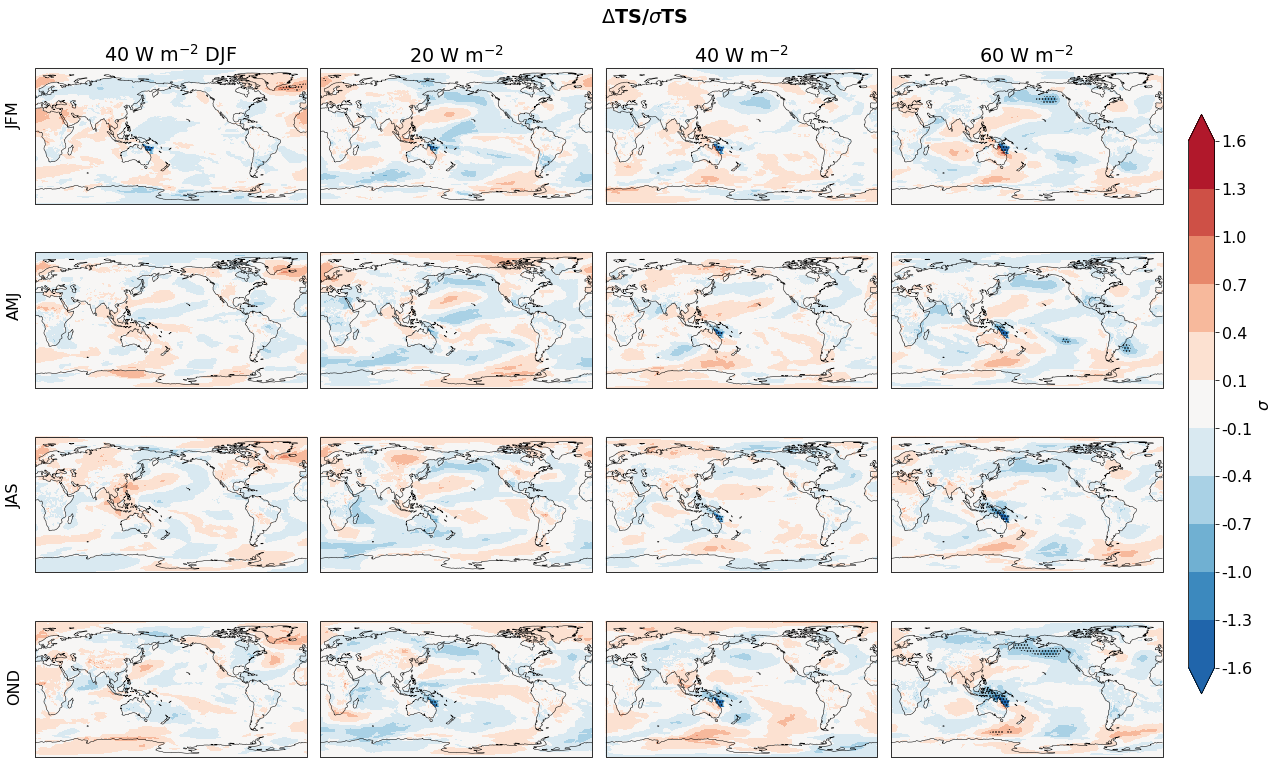

In [30]:
plot_seasonal_diffs_with_ttest(pert,control,'TS', -1.6, 1.6, standardize=True, domain = 'global',)

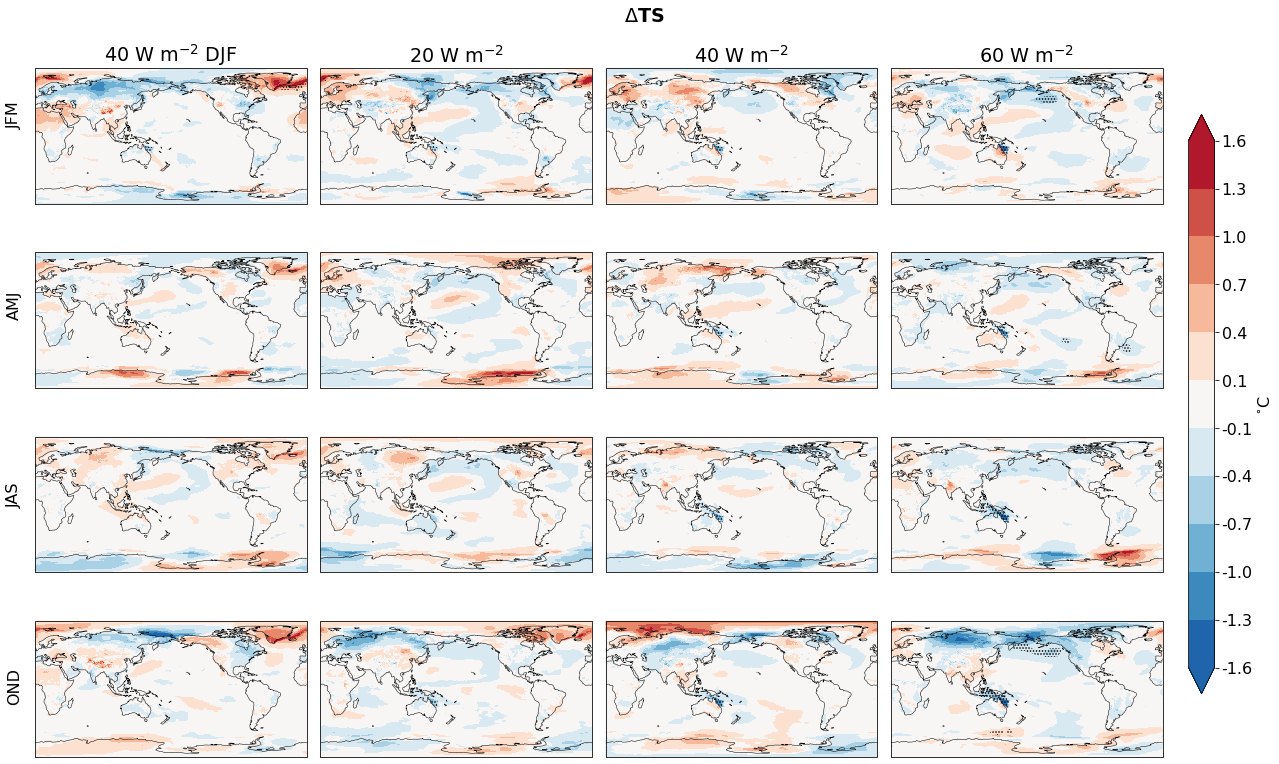

In [31]:
plot_seasonal_diffs_with_ttest(pert,control,'TS', -1.6, 1.6, standardize=False, domain = 'global')

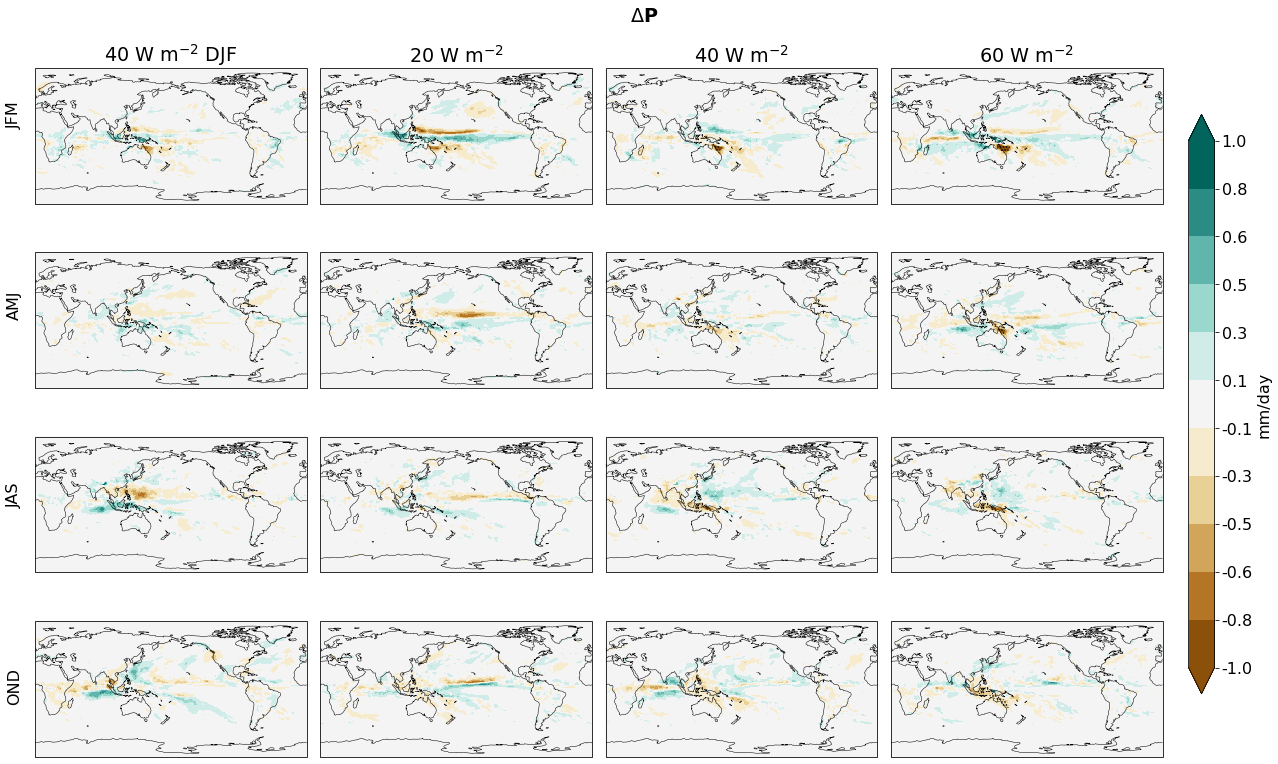

In [32]:
plot_seasonal_diffs_with_ttest(pert,control,'PRECT', -1, 1, standardize=False, domain = 'global',)

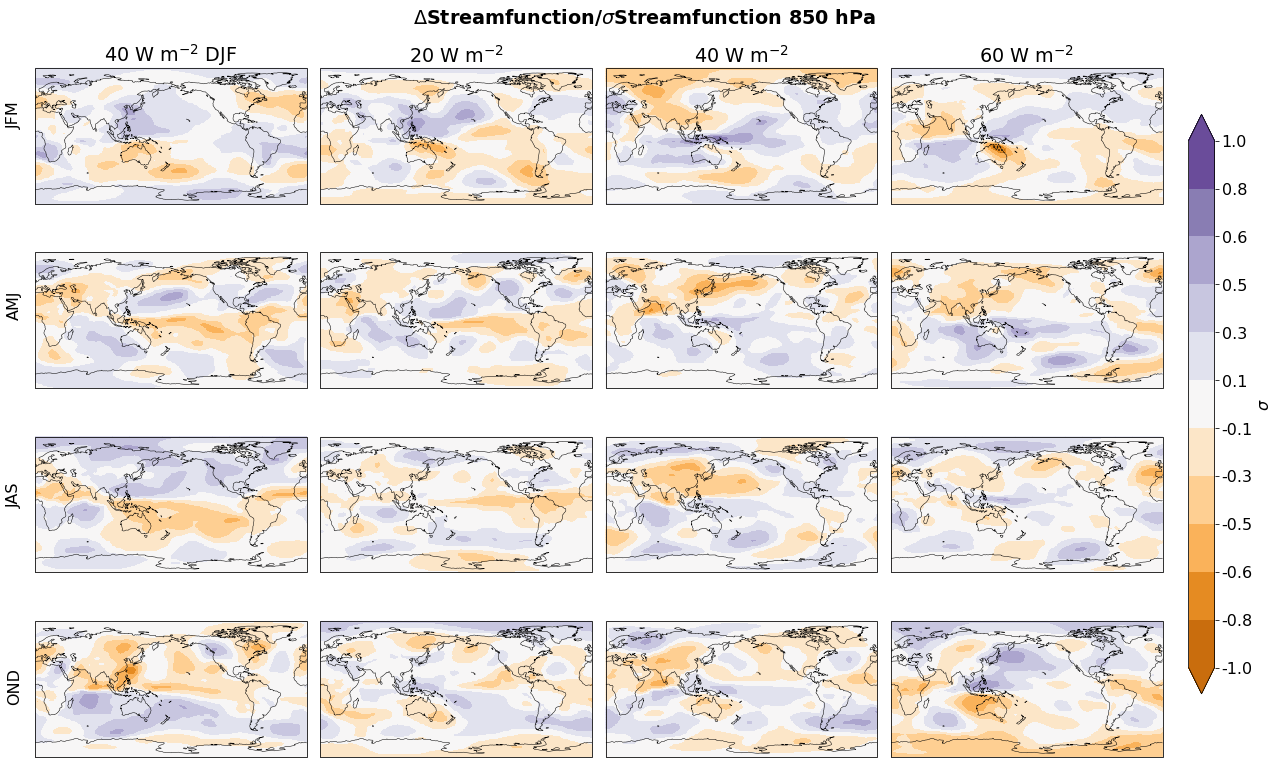

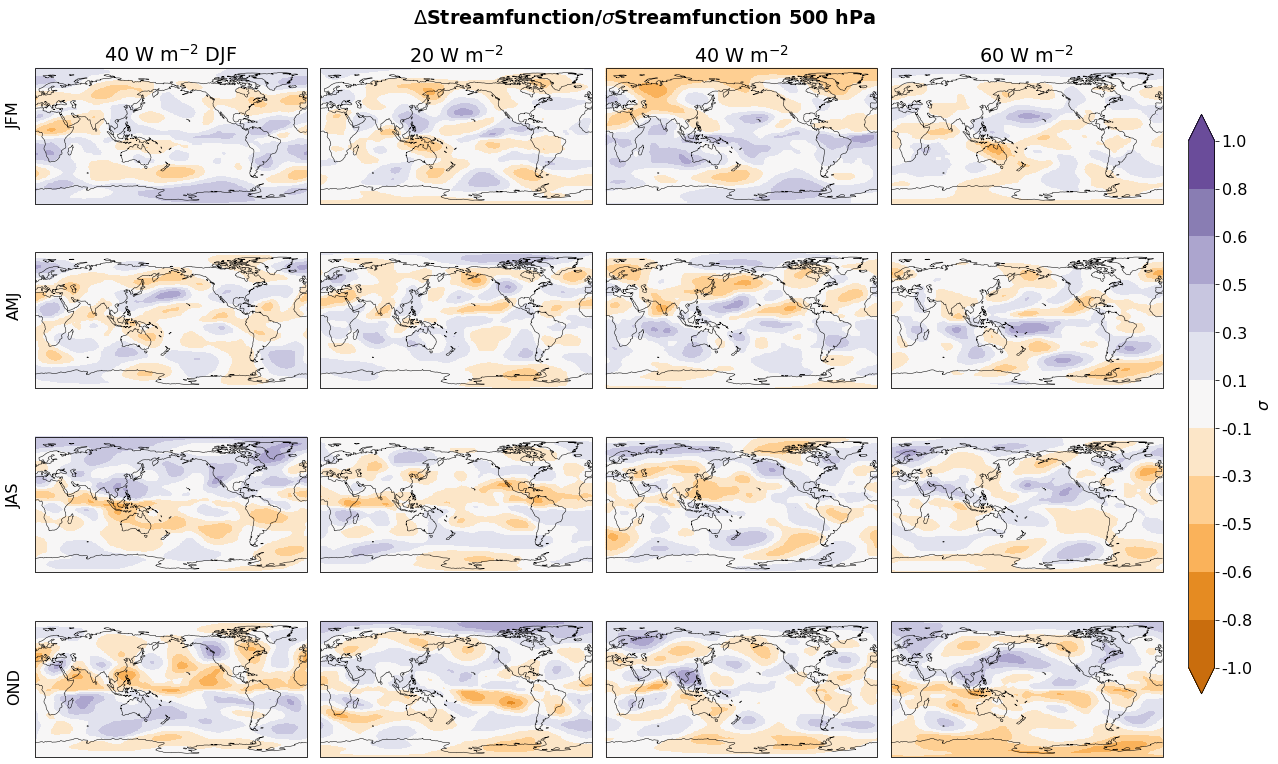

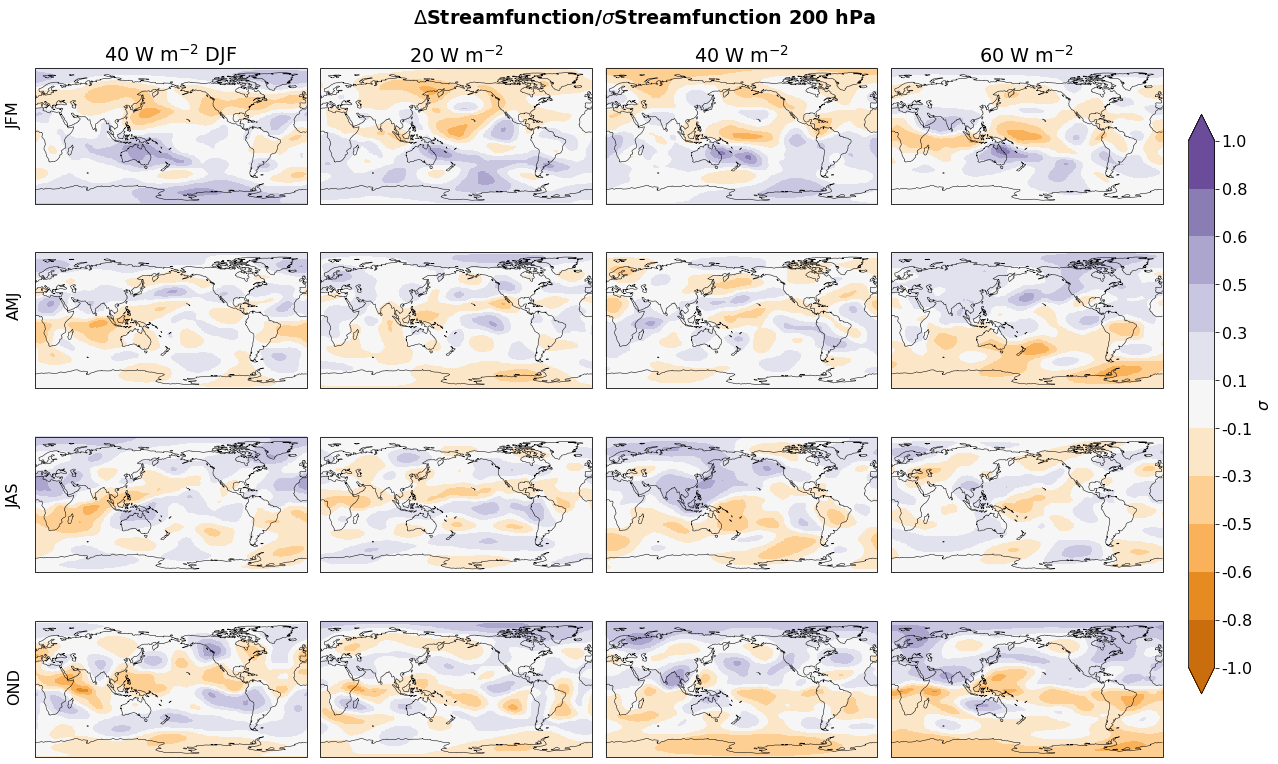

In [33]:
plot_seasonal_diffs_with_ttest(pert,control,'SF',-1, 1,  lev=25, domain='global',standardize=True)
plot_seasonal_diffs_with_ttest(pert,control,'SF',-1, 1,  lev=20, domain='global',standardize=True)
plot_seasonal_diffs_with_ttest(pert,control,'SF',-1, 1, lev=14, domain='global',standardize=True)

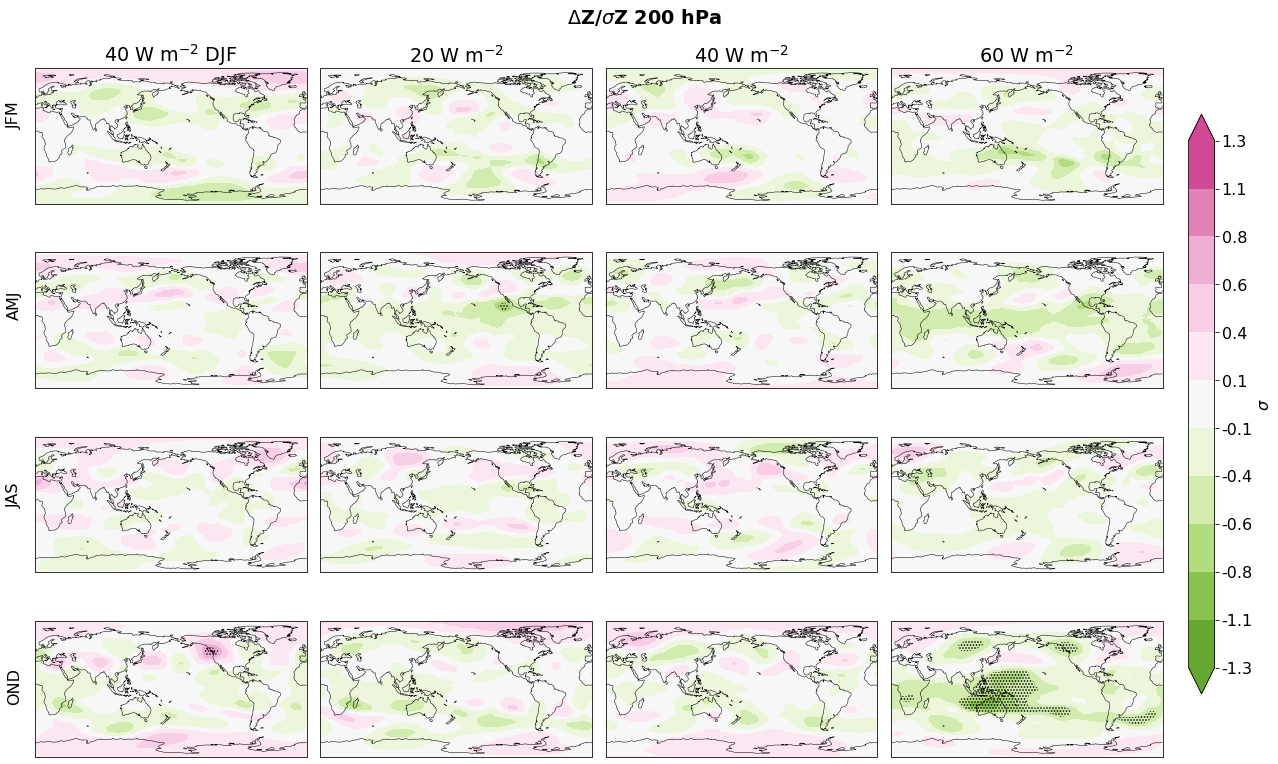

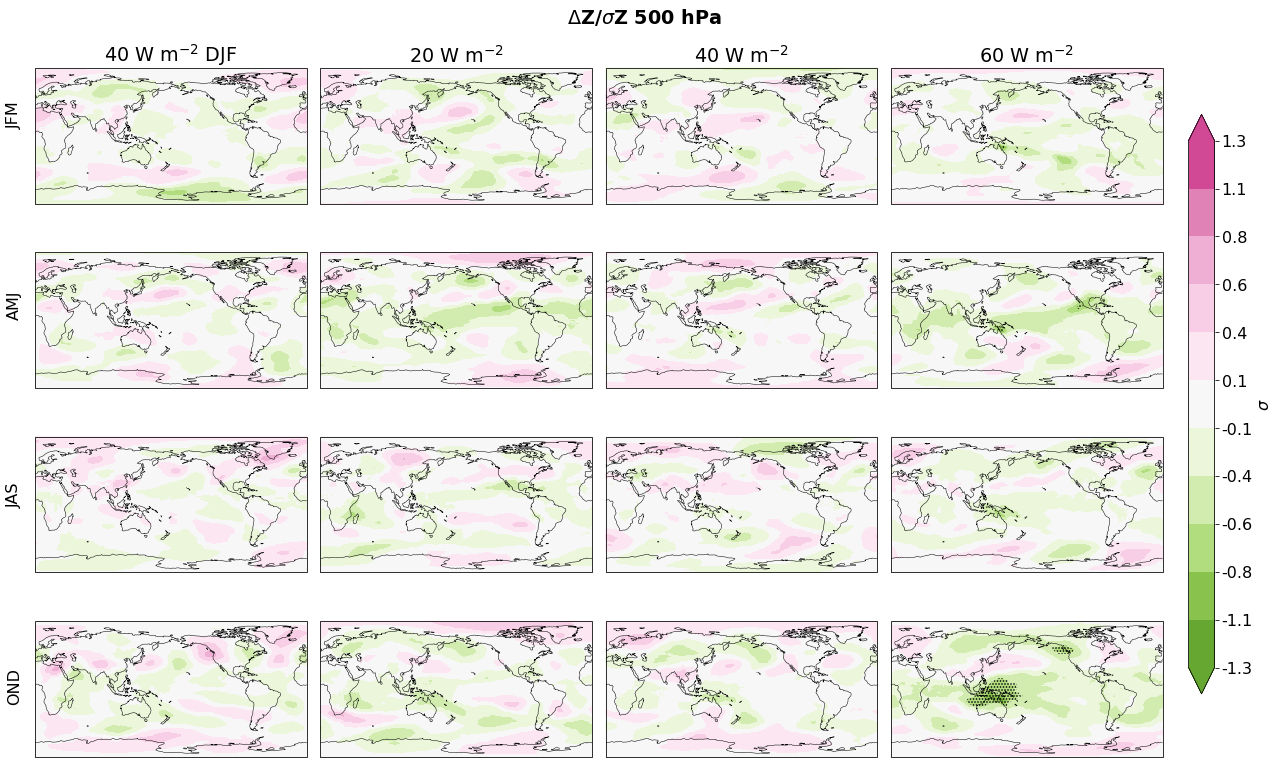

In [34]:
plot_seasonal_diffs_with_ttest(pert,control,'Z3', -1.3, 1.3, lev=14,standardize=True,domain='global')
plot_seasonal_diffs_with_ttest(pert,control,'Z3', -1.3, 1.3, lev=20,standardize=True,domain='global')
#plot_seasonal_diffs_with_ttest(pert,control,'Z3', -1.3, 1.3, lev=25,standardize=True,domain='global')